# Electron Cooling

In [1]:
%load_ext autoreload

## Notebook Initialization

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle
import copy

from astropy.io import fits


np.set_printoptions(threshold=np.nan)


import darkhistory.physics as phys
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.transferfunction as tf
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec

## Import ICS Tables

In [3]:
raw_nonrel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

## Set Up Abscissa for Testing

In [4]:
mwimp = 1e12
neng = 500
dlneng = np.log(mwimp)/neng
elecbins = np.exp(np.arange(neng+1)*dlneng)
englow = elecbins[0:neng]
enghigh = elecbins[1:]
eleceng = np.sqrt(englow*enghigh)

nphoteng = 500
dlnphoteng = np.log(mwimp/1e-2)/nphoteng
photenglow = 1e-2*np.exp(np.arange(nphoteng)*dlnphoteng)
photenghigh = 1e-2*np.exp((np.arange(nphoteng)+1)*dlnphoteng)
photeng = np.sqrt(photenglow*photenghigh)

T = phys.TCMB(1000)

ICS_tf = ics_spec(eleceng, photeng, T, 
                  nonrel_tf = raw_nonrel_ICS_tf, rel_tf = raw_rel_ICS_tf
                 )

engloss_tf = engloss_spec(eleceng, photeng, T, 
                          nonrel_tf = raw_engloss_tf, 
                          rel_tf = raw_rel_ICS_tf
                         )

sec_elec_tf = copy.deepcopy(engloss_tf)

for in_eng, spec in zip(sec_elec_tf.get_in_eng(), sec_elec_tf):
    spec.engloss_rebin(in_eng, sec_elec_tf.get_in_eng())

In [14]:
loweng = 250
eleceng_high = eleceng[eleceng > loweng]
eleceng_high_ind = np.arange(eleceng.size)[eleceng > loweng]

sec_phot_tf = tf.TransFuncAtRedshift([], dlnz=-1, rs=ICS_tf.rs)
sec_lowengelec_tf = tf.TransFuncAtRedshift([], dlnz=-1, rs=ICS_tf.rs)
cont_loss_vec = np.zeros_like(eleceng)
deposited_vec = np.zeros_like(eleceng)


delta_spec = np.zeros_like(eleceng)
for i,eng in zip(np.arange(eleceng.size), eleceng):
    delta_spec *= 0
    delta_spec[i] = 1
    if i < eleceng_high_ind[0]:
        sec_phot_N = np.zeros_like(photeng)
        sec_elec_N = delta_spec
    else:
        sec_phot_N = spectools.scatter(
            ICS_tf, mode='N', out_mode='N',
            eng_arr = eleceng, N_arr = delta_spec, new_eng = photeng
        )
        sec_elec_N = spectools.scatter(
            sec_elec_tf, mode='N', out_mode='N',
            eng_arr = eleceng, N_arr = delta_spec, new_eng = eleceng
        )
    # Continuum loss
    continuum_engloss = -phys.thomson_xsec*phys.c*phys.CMB_eng_density(T)
    # Total number of primaries
    pri_elec_totN = np.sum(sec_elec_N)
    # Total energy loss
    pri_elec_totengloss = pri_elec_totN*eng - np.sum(sec_elec_N*eleceng)
    # 'Deposited' energy
    deposited_eng = pri_elec_totengloss - (np.sum(sec_phot_N*photeng) + continuum_engloss)
    if eng + phys.me > 20*phys.me:
        # If relativistic, pri_elec_totengloss does not include the original CMB energy. 
        deposited_eng += continuum_engloss
        continuum_engloss = 0

    if eng > loweng:
        # Normalize all quantities to one scattering. 
        sec_phot_N /= pri_elec_totN
        sec_elec_N /= pri_elec_totN
        continuum_engloss /= pri_elec_totN
        deposited_eng /= pri_elec_totN
        # total number of electrons in sec_elec_N is now 1. 
        
        # remove the self-scattering bin, re-scale the energy. 
        fac = 1 - sec_elec_N[i]*eleceng[i]/(np.sum(sec_elec_N)*eng)
        sec_elec_N[i] = 0
        sec_phot_N /= fac
        sec_elec_N /= fac
        continuum_engloss /= fac
        deposited_eng /= fac
        
        
        scattered_elec_N = sec_elec_N[0:i]
        resolved_lowengelec_spec_N = spectools.scatter(
            sec_lowengelec_tf, mode='N', out_mode='N',
            eng_arr = eleceng[0:i], N_arr = scattered_elec_N,
            new_eng = eleceng
        )
        resolved_phot_spec_N = spectools.scatter(
            sec_phot_tf, mode='N', out_mode='N',
            eng_arr = eleceng[0:i], N_arr = scattered_elec_N,
            new_eng = photeng
        )
        sec_phot_N += resolved_phot_spec_N
        sec_elec_N = resolved_lowengelec_spec_N
        continuum_engloss += np.dot(scattered_elec_N, cont_loss_vec[0:i])
        deposited_eng += np.dot(scattered_elec_N, deposited_vec[0:i])
#         sec_elec_N[eleceng_high_ind[0]:] *= 0

            
    
    sec_phot_toteng = np.sum(sec_phot_N*photeng)
    # Photon spectrum should have total energy eng +
    # total energy of upscattered photons.
    
    sec_phot_spec = spectools.rebin_N_arr(sec_phot_N, photeng)
    sec_elec_spec = spectools.rebin_N_arr(sec_elec_N, eleceng)
    sec_phot_spec.in_eng = eng
    sec_elec_spec.in_eng = eng
    sec_phot_spec.rs = ICS_tf.rs
    sec_elec_spec.rs = ICS_tf.rs
    
    sec_phot_tf.append(sec_phot_spec)
    sec_lowengelec_tf.append(sec_elec_spec)
    cont_loss_vec[i] = continuum_engloss
    deposited_vec[i] = deposited_eng
    
    # Energy conservation check
    if eng <= loweng and eng > loweng:
        conservation_check = (
            np.sum(sec_elec_N)*eng - np.sum(sec_elec_N*eleceng)
            - (np.sum(sec_phot_N*photeng) + continuum_engloss) - deposited_eng
        )
        print(np.sum(sec_elec_N)*eng, np.sum(sec_elec_N*eleceng), 
             np.sum(sec_phot_N*photeng), continuum_engloss, deposited_eng, conservation_check)
    else:
        conservation_check = (
            eng - np.sum(sec_elec_N*eleceng) - np.sum(sec_phot_N*photeng)
            - continuum_engloss - deposited_eng
        )
        print(eng,'**', np.sum(sec_elec_N*eleceng), np.sum(sec_phot_N*photeng),
              continuum_engloss, deposited_eng, conservation_check
             )
    if conservation_check/eng > 1e-10:
        raise RuntimeError('Conservation of energy check failed.')
    
    # Force conservation of energy
    deposited_eng += conservation_check
    

1.02801629813 ** 1.02801629813 0.0 -0.005196699723732948 0.00519669972373 0.0
1.08642562362 ** 1.08642562362 0.0 -0.005196699723732948 0.00519669972373 0.0
1.1481536215 ** 1.1481536215 0.0 -0.005196699723732948 0.00519669972373 0.0
1.21338885046 ** 1.21338885046 0.0 -0.005196699723732948 0.00519669972373 0.0
1.28233058266 ** 1.28233058266 0.0 -0.005196699723732948 0.00519669972373 0.0
1.35518941235 ** 1.35518941235 0.0 -0.005196699723732948 0.00519669972373 0.0
1.43218789927 ** 1.43218789927 0.0 -0.005196699723732948 0.00519669972373 0.0
1.51356124844 ** 1.51356124844 0.0 -0.005196699723732948 0.00519669972373 0.0
1.59955802861 ** 1.59955802861 0.0 -0.005196699723732948 0.00519669972373 0.0
1.69044093164 ** 1.69044093164 0.0 -0.005196699723732948 0.00519669972373 0.0
1.78648757485 ** 1.78648757485 0.0 -0.005196699723732948 0.00519669972373 0.0
1.8879913491 ** 1.8879913491 0.0 -0.005196699723732948 0.00519669972373 0.0
1.99526231497 ** 1.99526231497 0.0 -0.005196699723732948 0.005196699

In [6]:
ICS_test_filename = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_test.fits"
ICS_test = fits.open(ICS_test_filename)
ICS_test_spec = ICS_test[0].data
ICS_test_spec = np.transpose(ICS_test_spec)
ICS_test_list_spec = [Spectrum(photeng, arr, in_eng=in_eng) for (arr, in_eng) in zip(ICS_test_spec, eleceng)]
ICS_test_tf = tf.TransFuncAtRedshift(ICS_test_list_spec, dlnz=-1)

[0.0001, 10000000000000.0, 0.0001, 1000000.0]

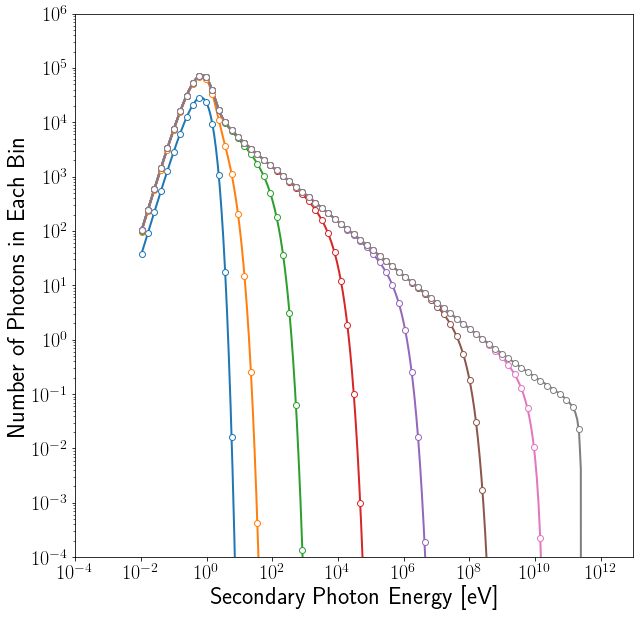

In [13]:
log_bin_width = spectools.get_log_bin_width(sec_phot_tf.get_eng())


ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([3.1e3, 3.1e5,3.1e6, 3.1e7, 3.1e8, 3.1e9, 3.1e10, 3.1e11])

sec_phot_tf.plot(ax, ind=comp_elec_kineng, fac=log_bin_width*sec_phot_tf.get_eng(), indtype='in_eng', linewidth=2)

plt.gca().set_prop_cycle(None)

ICS_test_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=0, marker='o', markersize='6', 
    markerfacecolor='w', markevery=7,)
# sec_phot_tf.plot(ax, ind=145, fac=log_bin_width*sec_phot_tf.get_eng(), indtype='ind', linewidth=2)
# ICS_test_tf.plot(ax, ind=145, indtype='ind', linewidth=0, marker='o', markersize='6', 
#     markerfacecolor='w', markevery=10,)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Secondary Photon Energy [eV]',fontsize=24)

plt.ylabel('Number of Photons in Each Bin',fontsize=24)
plt.axis([1e-4, 1e13, 1e-4, 1e6])